<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [2]:
taxi_df = pd.read_csv('data/yellow_tripdata_2019-01.csv')

# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [3]:
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [4]:
taxi_df.shape

(7667792, 18)

In [5]:
taxi_data = taxi_df[['tpep_pickup_datetime',
                     'tpep_dropoff_datetime',
                     'passenger_count',
                     'trip_distance',
                     'RatecodeID',
                     'PULocationID',
                     'DOLocationID',
                     'payment_type',
                     'total_amount'
                    ]]

In [6]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667792 entries, 0 to 7667791
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   passenger_count        int64  
 3   trip_distance          float64
 4   RatecodeID             int64  
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   payment_type           int64  
 8   total_amount           float64
dtypes: float64(2), int64(5), object(2)
memory usage: 526.5+ MB


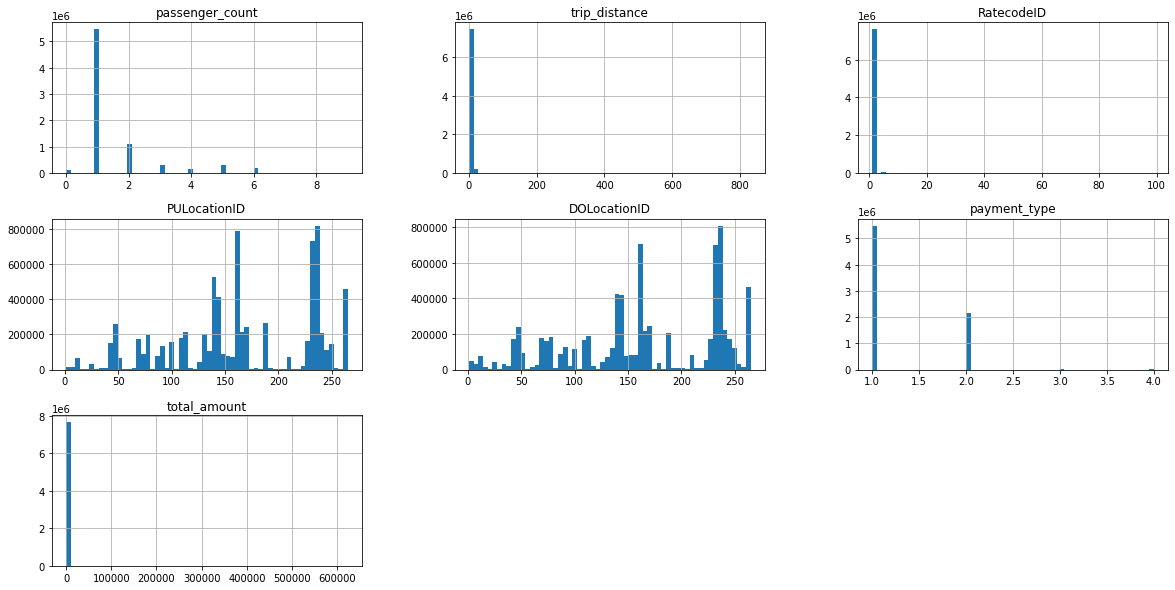

In [7]:
taxi_data.hist(figsize=(20,10), bins=60);

In [8]:
taxi_data['passenger_count'].value_counts()

1    5456121
2    1114106
5     323842
3     314721
6     200811
4     140753
0     117381
8         29
7         19
9          9
Name: passenger_count, dtype: int64

In [9]:
taxi_data['RatecodeID'].value_counts()

1     7430139
2      166090
5       54569
3       11801
4        4895
99        252
6          46
Name: RatecodeID, dtype: int64

#### RatecodeID possible values

1=Standard rate

2=JFK

3=Newark

4=Nassau or Westchester

5=Negotiated fare

6=Group ride

99=Probably missing RateID, just 252, probably can be dropped

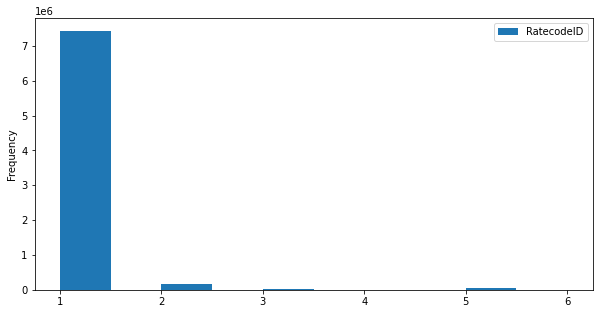

In [10]:
taxi_data[taxi_data['RatecodeID']<99].reset_index().plot(kind='hist',y='RatecodeID',x='index',figsize=(10,5));

In [11]:
taxi_data['payment_type'].value_counts()

1    5486027
2    2137415
3      33186
4      11164
Name: payment_type, dtype: int64

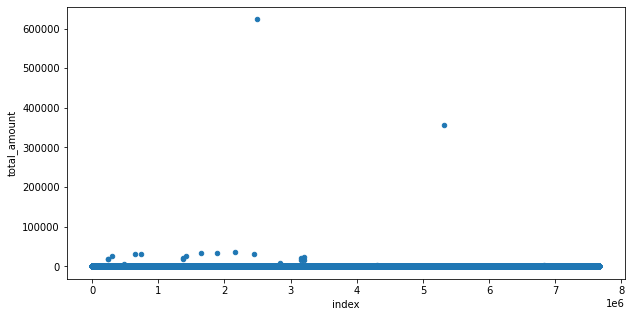

In [12]:
taxi_data.reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

_comment_: very few values above __1000__

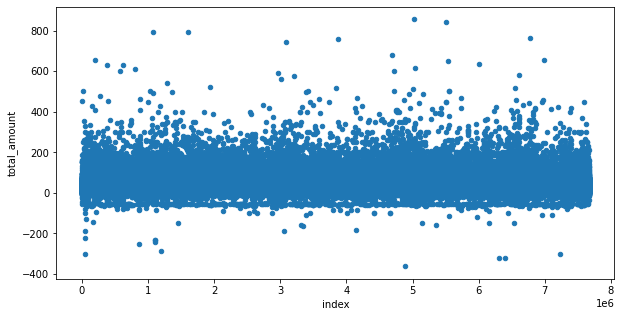

In [13]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

_comment_: once we remove values above 1000, we still see __negative values__

In [14]:
print(taxi_data[taxi_data['total_amount']<0].shape)

(7131, 9)


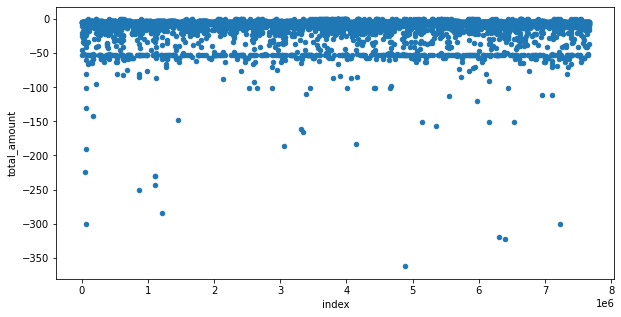

In [15]:
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

In [16]:
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


In [17]:
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

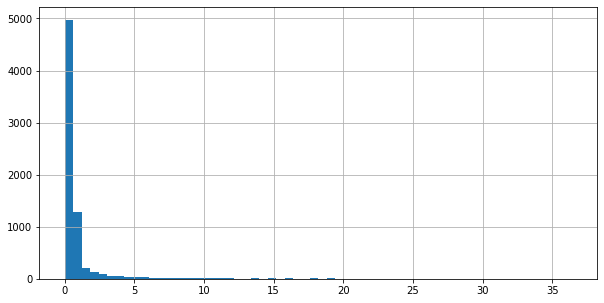

In [18]:
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60,figsize=(10,5));

we can safely remove the data containing a __negative total amount__

In [19]:
print(taxi_data[taxi_data['total_amount']==0].shape)

(1414, 9)


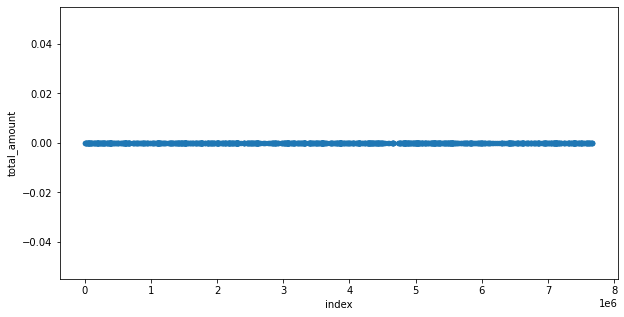

In [20]:
taxi_data[taxi_data['total_amount']==0].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5));

In [21]:
taxi_data[taxi_data['total_amount']==0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1,0.0,5,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1,0.0,5,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1,0.0,1,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1,0.0,1,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1,0.0,1,264,7,2,0.0


In [22]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

1    815
2    569
3     29
4      1
Name: payment_type, dtype: int64

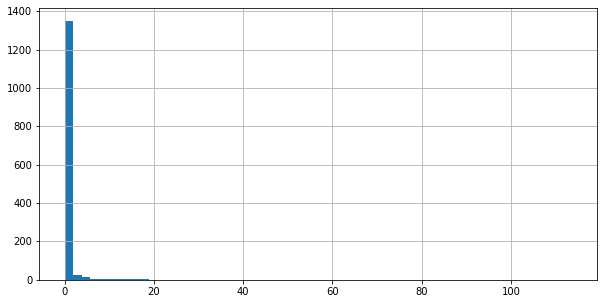

In [23]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60,figsize=(10,5));

In [24]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

0.00    1270
1.00       4
0.01       4
0.02       4
0.03       3
        ... 
0.59       1
0.18       1
5.70       1
0.87       1
1.04       1
Name: trip_distance, Length: 110, dtype: int64

what about the high values?

In [25]:
taxi_data[taxi_data['total_amount']>500].shape

(56, 9)

In [26]:
taxi_data[taxi_data['total_amount']>300].shape

(307, 9)

In [27]:
taxi_data[taxi_data['total_amount']>100].shape

(10832, 9)

In [28]:
taxi_data[taxi_data['total_amount']>200].shape

(1166, 9)

In [29]:
taxi_data['total_amount'].mean()

15.68222215991253

We will cut on 200$, seems a fair level.

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [30]:
taxi_data_fltr = taxi_data[(taxi_data['total_amount']>=0)&(taxi_data['total_amount']<200)]

In [31]:
taxi_data_fltr.shape

(7659490, 9)

_checking missing values_

In [32]:
taxi_data_fltr.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

a _deep copy_ creates a new address of the dataframe in memory preserving the original one 

In [33]:
taxi_data_prepared = taxi_data_fltr.copy()

In [34]:
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

fixing types

In [35]:
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])

In [36]:
taxi_data_prepared.loc[:,'RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:,'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:,'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:,'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [37]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [38]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)

In [39]:
taxi_data_prepared['transaction_year'] = taxi_data_prepared['transaction_date'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['transaction_date'].dt.month
taxi_data_prepared['transaction_day'] = taxi_data_prepared['transaction_date'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour

In [40]:
taxi_data_prepared.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,15
5,2018-11-28 16:25:49,2018-11-28 16:28:26,5,0.0,1,193,193,2,13.31,2018-11-28,2018,11,28,16
6,2018-11-28 16:29:37,2018-11-28 16:33:43,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,16
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,163,229,1,9.05,2019-01-01,2019,1,1,0
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,229,7,1,18.50,2019-01-01,2019,1,1,0
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,141,234,1,13.00,2019-01-01,2019,1,1,0


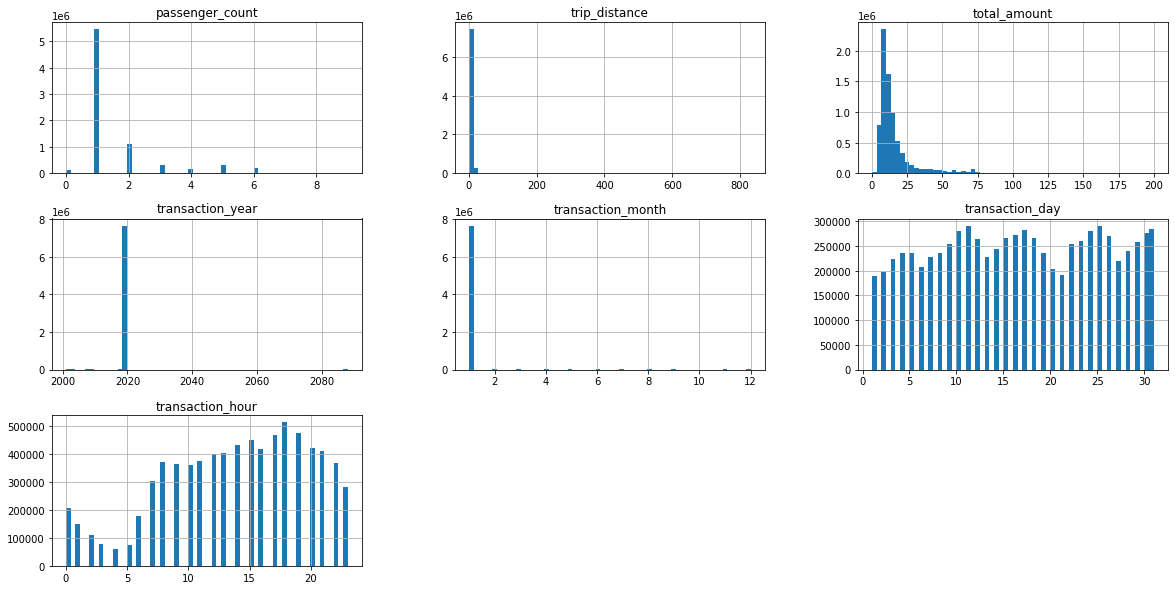

In [41]:
taxi_data_prepared.hist(figsize=(20,10),bins=60);

In [42]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

In [43]:
taxi_data_prepared.shape

(7658954, 14)

In [44]:
taxi_data_prepared.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'transaction_date', 'transaction_year',
       'transaction_month', 'transaction_day', 'transaction_hour'],
      dtype='object')

noting down columns

In [45]:
cat_clmns = ['PULocationID','transaction_date','transaction_month', 'transaction_day', 'transaction_hour']
num_clmns = ['trip_distance','total_amount']
all_clmns = cat_clmns + num_clmns

In [46]:
main_taxi_df = taxi_data_prepared[all_clmns]
print(main_taxi_df.shape)
main_taxi_df.head(3)

(7658954, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05


aggregate data

In [47]:
taxi_grpd_by_region = main_taxi_df.groupby(cat_clmns).mean().reset_index()

In [48]:
taxi_grpd_by_region['count_of_transactions'] = main_taxi_df.groupby(cat_clmns).count().reset_index()['total_amount']

In [49]:
taxi_grpd_by_region.shape

(102556, 8)

In [50]:
taxi_grpd_by_region.head(5)

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


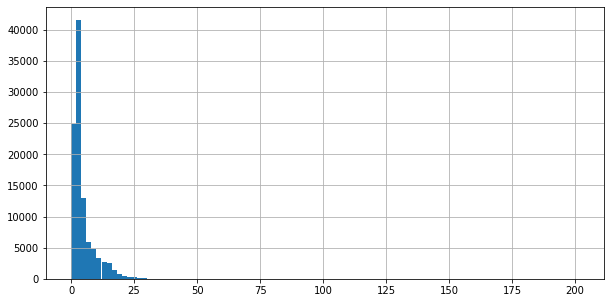

In [51]:
taxi_grpd_by_region['trip_distance'].hist(bins=100,figsize=(10,5));

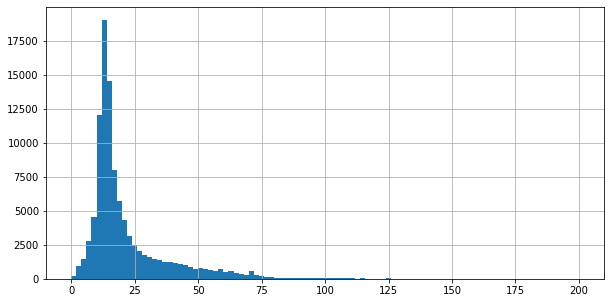

In [52]:
taxi_grpd_by_region['total_amount'].hist(bins=100,figsize=(10,5));

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

In [53]:
data_bench_model = taxi_grpd_by_region.copy()

In [62]:
cat_ftrs_bench = ['PULocationID',
                  'transaction_month',
                  'transaction_day',
                  'transaction_hour']
# input_ftr_bench = cat_ftrs_bench + ['trip_distance']
input_ftr_bench = cat_ftrs_bench
target_ftr_bench = 'total_amount'

_trip_distance_ is a data leakage! it directly correlates with the the _total_amount_

## __5.1 Train-test split__

In [63]:
from sklearn.model_selection import train_test_split

X_bench = data_bench_model[input_ftr_bench]
y_bench = data_bench_model[target_ftr_bench]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

## __5.2 Fit a model to the data__

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b,y_train_b)

DecisionTreeRegressor(max_depth=10)

## __5.3 Model evaluation__

In [65]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean absolute error +/-', mean_absolute_error(y_test_b,y_pred_b), 'dollars')
print('mean squared error ', mean_squared_error(y_test_b,y_pred_b))
print('root mean squared error', sqrt(mean_squared_error(y_test_b,y_pred_b)))
print('r2 score ', r2_score(y_test_b,y_pred_b), ' how good (1 is perfect, -1 is ugly)')

mean absolute error +/- 9.778013506686172 dollars
mean squared error  217.23486109795616
root mean squared error 14.738889411958967
r2 score  0.2247845492430408  how good (1 is perfect, -1 is ugly)


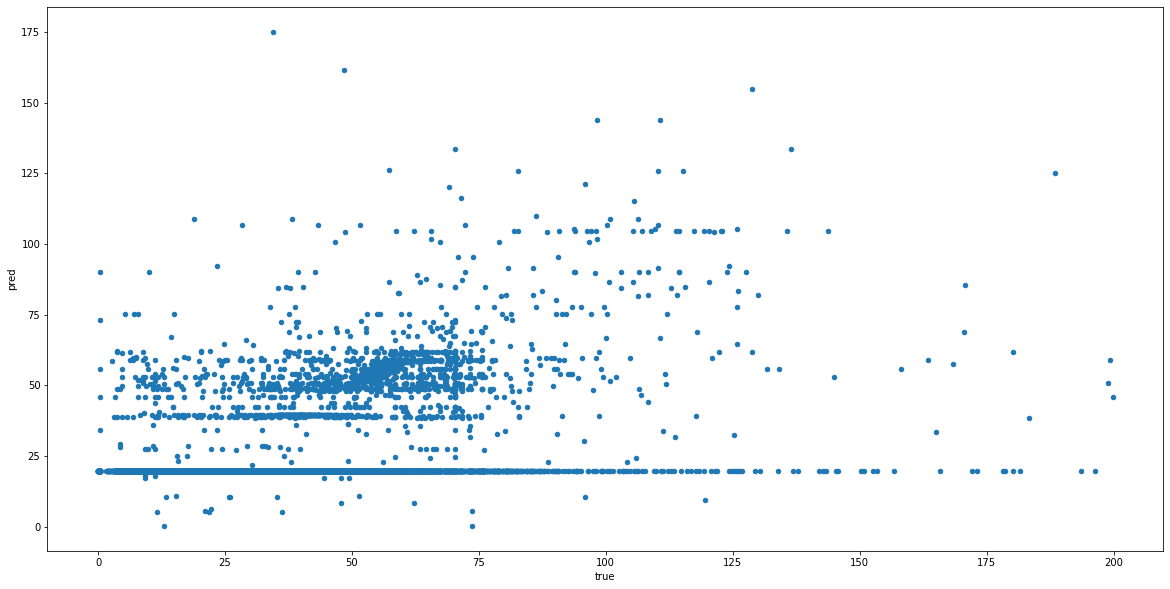

In [66]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred');

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## 7.1. Decision tree <a id='decision_tree'></a>

## 7.2. Random forest <a id='random_forest'></a>

## 7.3. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)